In [61]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
from h3 import h3

# 0. Connect to Mongo and define a specific database

In [62]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [63]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

2.1917238235473633


In [64]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


# 2. Divide the sample time period in two and compute time changes

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

In [65]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2014-06-30T00:00:00.000000000', '2013-09-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2013-03-31T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2015-03-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2013-06-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2013-12-31T00:00:00.000000000', '2014-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [66]:
# 2 Define a midpoint date to separate the two periods in the data. 
import datetime
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2013,6,30))

..\analysis.py:961: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2dif=df2.groupby('_id')['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Coding \ _p0 is the average level of tweets counts in the first period \ _dif is the difference between periods \ _ch stands for % changes \ _chb is an alternative % change only for those hexs with more than 50 tweets.

In [67]:
gdfchanges.head(10)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89be081a047ffff,-32.000000,-32.000000,NaN,-32.000000,32.500000,32.500000,NaN,32.500000,-0.984615,-0.984615,NaN,-0.984615,NaN,NaN,NaN,NaN,"POLYGON ((-34.059 150.662, -34.057 150.661, -3..."
1,89be081a08bffff,-1.375000,-1.375000,NaN,-1.375000,2.000000,2.000000,NaN,2.000000,-0.687500,-0.687500,NaN,-0.687500,NaN,NaN,NaN,NaN,"POLYGON ((-34.071 150.665, -34.069 150.664, -3..."
2,89be081a213ffff,0.214286,0.214286,NaN,1.125000,0.500000,0.500000,NaN,0.500000,0.428571,0.428571,NaN,2.250000,NaN,NaN,NaN,NaN,"POLYGON ((-34.045 150.671, -34.043 150.671, -3..."
3,89be081a21bffff,-0.083333,-0.083333,NaN,-0.083333,0.333333,0.333333,NaN,0.333333,-0.250000,-0.250000,NaN,-0.250000,NaN,NaN,NaN,NaN,"POLYGON ((-34.042 150.672, -34.040 150.672, -3..."
4,89be081a28bffff,1.714286,1.714286,NaN,1.714286,1.000000,1.000000,NaN,1.000000,1.714286,1.714286,NaN,1.714286,NaN,NaN,NaN,NaN,"POLYGON ((-34.048 150.674, -34.046 150.673, -3..."
5,89be081a2c7ffff,NaN,NaN,NaN,0.416667,1.000000,1.000000,NaN,0.250000,NaN,NaN,NaN,1.666667,NaN,NaN,NaN,NaN,"POLYGON ((-34.045 150.675, -34.043 150.675, -3..."
6,89be081a2d7ffff,2.555556,2.555556,NaN,2.555556,2.333333,2.333333,NaN,2.333333,1.095238,1.095238,NaN,1.095238,NaN,NaN,NaN,NaN,"POLYGON ((-34.047 150.678, -34.045 150.678, -3..."
7,89be081a40bffff,-1.547619,-1.547619,NaN,-1.547619,2.333333,2.333333,NaN,2.333333,-0.663265,-0.663265,NaN,-0.663265,NaN,NaN,NaN,NaN,"POLYGON ((-34.080 150.680, -34.078 150.679, -3..."
8,89be081a44fffff,0.166667,0.166667,NaN,0.166667,0.333333,0.333333,NaN,0.333333,0.500000,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN,"POLYGON ((-34.074 150.683, -34.072 150.682, -3..."
9,89be081a45bffff,-2.500000,-2.500000,NaN,-2.500000,3.000000,3.000000,NaN,3.000000,-0.833333,-0.833333,NaN,-0.833333,NaN,NaN,NaN,NaN,"POLYGON ((-34.076 150.689, -34.074 150.689, -3..."


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

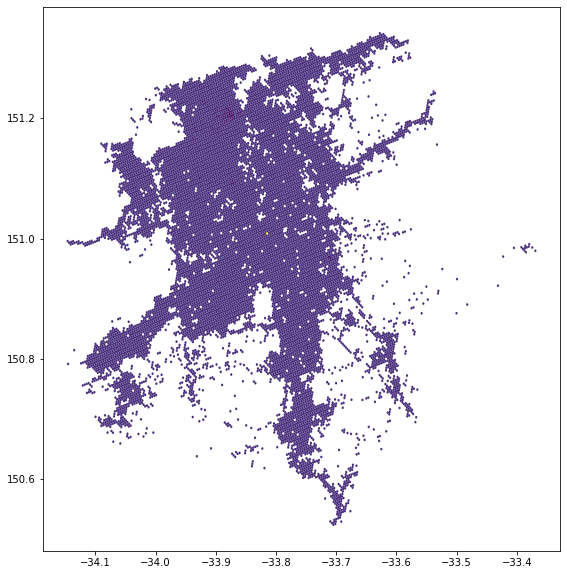

In [68]:
# Plot example
gdfchanges.plot('nonresidents_dif')
gdfchanges.crs

## 3. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [69]:
#1 Get centroids
gdfchanges_points = myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

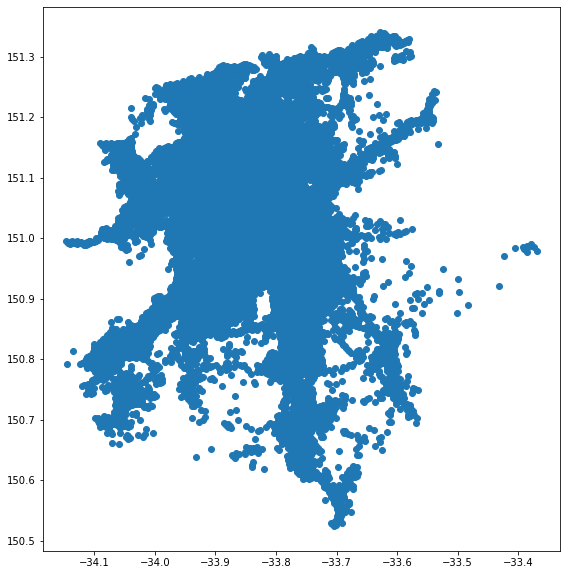

In [70]:
gdfchanges_points.plot()

In [71]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

tracts = gpd.read_file(shp_path/"syd.geojson")
tracts = tracts.to_crs({'init': 'epsg:4326'})

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

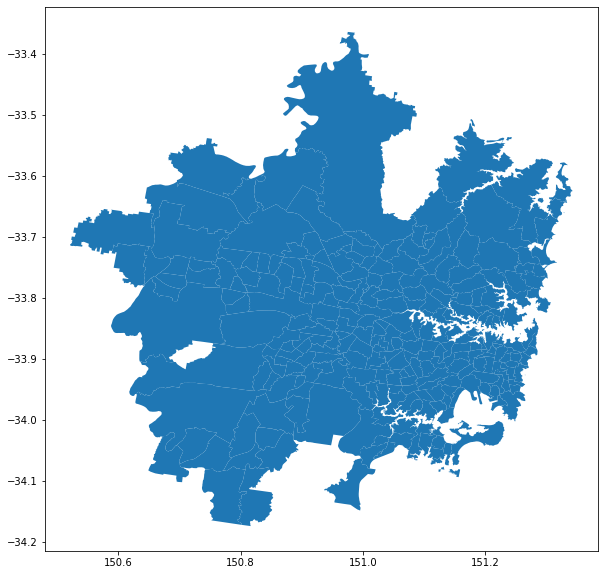

In [72]:
tracts.plot()
tracts.crs

In [76]:
# # 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [77]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types


In [75]:
tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'TYPE']].groupby('TYPE').agg(['mean','count','sem'])
#nonresidents_p0


KeyError: "['TYPE'] not in index"